## CIP-50 Leverage-based Pool Ranking Analysis
CCGarant, 7/27/22, @TheStophe

Supporting work for the CIP-50 leveraged-base pool ranking system, comparing Daedalus ranking to CIP-50 Ranking.




### Ranking Equation

The recommended ranking equation starts with a highest score of 10. The pools are down-ranked solely based on leverage and fees factors.


    //equation
    ranking_score = 10 - max{leverage_factor,saturation_factor} - fee_factor

    //variables
    leverage_factor = 10 * (pool_leverage/L)^A
    saturation_factor = 10 * (pool_stake(1+C)/saturation_stake)^B
    fee_factor = D * pool_fee_margin

    //parameters
    - A is 2.0, has range (0,10.0), can be tweaked
    - B is 3.0, has range (0,10.0), can be tweaked
    - C is 0.1, has range (0,1.0), can be tweaked
    - pool_leverage = delegation / pledge
    - pool_stake = pledge + delegation
    - saturation_stake = pool_size soft-cap (e.g., 68Mâ‚³ based on k-parameter)
    - D is 50, has range (0-100) ish to be harsh, can be tweaked
    - pool_fee_margin is in range (0-100)% (fixed fee + margin combined)

To evaluate rank using the current reward scheme:

    //current reward scheme only
    ranking_score = 10 - max{leverage_factor,saturation_factor} - fee_factor - fixed_fee_factor

    //variables
    //if fee = minFee, term drops out
    //if fee > minFee, term nonzero but loses relevance w/ increased stake
    //fixed fee matters less to rewards as stake grows, so too here
    fixed_fee_factor = E * (fee-minFee) / stake 

    //parameters
    - E is 50, has range (0,100), can be tweaked
    - fee cannot be less than minFee

### Ranking System

The pool ranking system will be a descending sorted list of ranking scores, with the highest score at the top:

    ranking = sort(ranking_score, order=descending)

The ranking score is intentionally simple and familiar. Pools will be ranked out of a score of 0-10, and "Graded" for ease per below. There can be many pools having the same ranking score.  All wallets should make transparent the knock-down factors that drove the pool's score.

| Grade | Score |
| --- | --- |
| A | 10-9 |
| B | 8-7 |
| C | 6-5 |
| D | 4-3 |
| F | 2-0 |

## Other Ranking Systems

- Adapools.org: [https://github.com/cexplorer/cexplorer.io/blob/main/doc/ranking.md](https://github.com/cexplorer/cexplorer.io/blob/main/doc/ranking.md)
- Eternl:
- Daedalus: 

In [48]:
import numpy as np
import pandas as pd
import bokeh as bk
import matplotlib.pyplot as plt

### Power Curves

Text(0.5, 1.0, 'Power Curve Squared y=x^2')

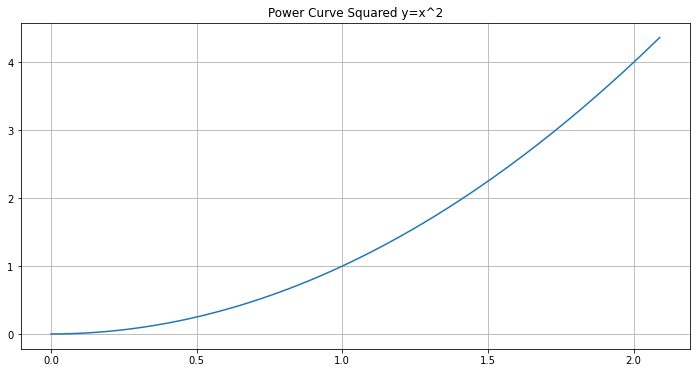

In [57]:
x = np.arange(0,2.1,.01)
y = np.power(x,2)
f = plt.figure(figsize=(12,6))
plt.plot(x,y)
plt.grid('on')
plt.title('Power Curve Squared y=x^2')

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.  ]


Text(0.5, 1.0, 'Power Curve y=x^A with A from 0 to 4.25 by 0.25')

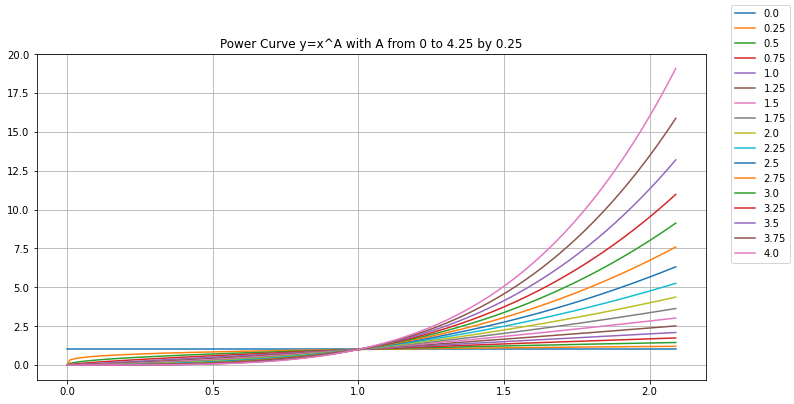

In [58]:
f = plt.figure(figsize=(12,6))
r = np.arange(0,4.25,.25)
print(r)

for r0 in r:
    y = np.power(x,r0)
    plt.plot(x,y)
plt.grid('on')
f.legend(r)
plt.title('Power Curve y=x^A with A from 0 to 4.25 by 0.25')


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


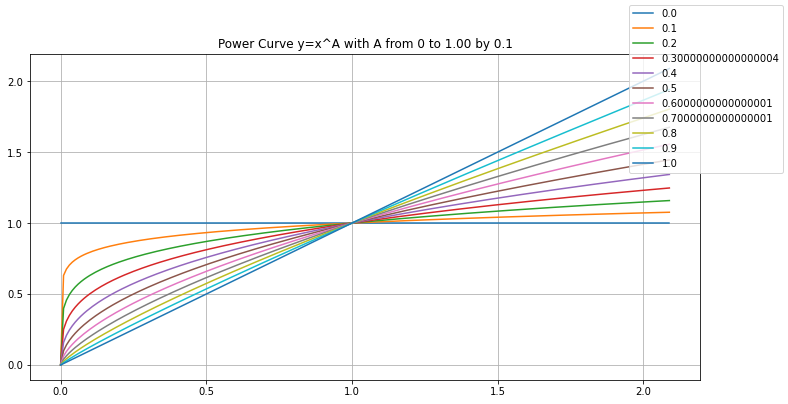

In [68]:
f = plt.figure(figsize=(12,6))
r = np.arange(0,1.1,.1)
print(r)

for r0 in r:
    y = np.power(x,r0)
    plt.plot(x,y)
plt.grid('on')
plt.title('Power Curve y=x^A with A from 0 to 1.00 by 0.1')
f.legend(r)


## Ranking Equations

In [94]:
#parameters

A = 2.0
B = 5.0
C = 0.9
D = 50
E = 100
L = 100
minFee = 340 #[Ada]
k = 500
# a0

In [91]:
#functions

def leverage_factor(poolLeverage,L,A):
    return 10*np.power(poolLeverage/L,A)

def saturation_factor(poolStake,saturationStake,B,C):
    return 2*np.power((poolStake/(saturationStake*C)),B)

def fee_factor(poolFeeMargin,D):
    return poolFeeMargin*D

def fixed_fee_factor(fee,minFee,stake,E):
    return E*(fee-minFee)/stake

def ranking_equation(leverage_factor,saturation_factor,fee_factor,fixed_fee_factor):
    return 10-np.max([leverage_factor,saturation_factor])-fee_factor-fixed_fee_factor


In [93]:
#checks, using SKY from spreadsheet as a reference

## SKY POOL
pledge = 123
stake = 6_080
fee = 340
margin = 0.01 #[1.0%]


lf =leverage_factor(49.4,L,A) #correct
sf = saturation_factor(6_203,68_555_404,B,C) #correct
ff = fee_factor(margin,D)
fff = fixed_fee_factor(fee,minFee,stake,E)
rank = ranking_equation(lf,sf,ff,fff)
rank_round_up = np.ceil(rank)

print(f'leverage_factor: {lf}')
print(f'saturation_factor: {sf}')
print(f'fee_factor: {ff}')
print(f'fixed_fee_factor: {fff}')
print(f'rank: {rank}')
print(f'rank_round_up: {rank_round_up}')

# matches spreadsheet ::check::

leverage_factor: 2.44036
saturation_factor: 2.0540824962918913e-20
fee_factor: 0.5
fixed_fee_factor: 0.0
rank: 7.05964
rank_round_up: 8.0


4